In [21]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# libraries used for graph and visulization
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,10

# libraries used for missing value 
import missingno as msno



from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold

Load Data From CSV

In [22]:
pd_loan =pd.read_csv("Loan_cheker.csv")

In [23]:
pd_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
Id                             10000 non-null int64
is_bad                         10000 non-null int64
emp_title                      9408 non-null object
emp_length                     10000 non-null object
home_ownership                 10000 non-null object
annual_inc                     9999 non-null float64
verification_status            10000 non-null object
pymnt_plan                     10000 non-null object
Notes                          6770 non-null object
purpose_cat                    10000 non-null object
purpose                        9996 non-null object
zip_code                       10000 non-null object
addr_state                     10000 non-null object
debt_to_income                 10000 non-null float64
delinq_2yrs                    9995 non-null float64
earliest_cr_line               9995 non-null object
inq_last_6mths                 9995 non-null floa

Create Copy for dataframe for doing analysis

In [24]:
pd_analysis =pd_loan.copy()

# Show missing value in matrix 

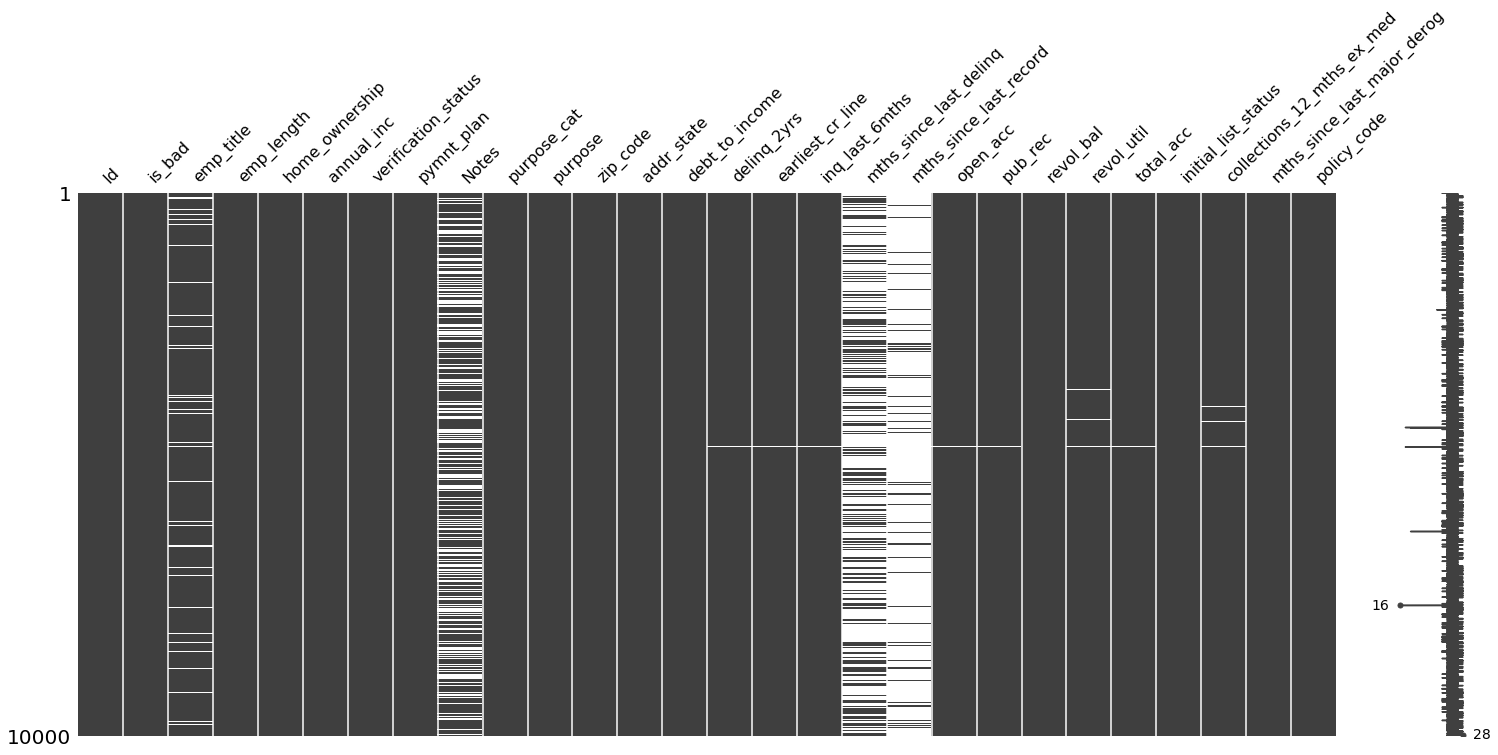

In [25]:
msno.matrix(pd_analysis)

In [26]:
pd_analysis.isnull().sum()

Id                                0
is_bad                            0
emp_title                       592
emp_length                        0
home_ownership                    0
annual_inc                        1
verification_status               0
pymnt_plan                        0
Notes                          3230
purpose_cat                       0
purpose                           4
zip_code                          0
addr_state                        0
debt_to_income                    0
delinq_2yrs                       5
earliest_cr_line                  5
inq_last_6mths                    5
mths_since_last_delinq         6316
mths_since_last_record         9160
open_acc                          5
pub_rec                           5
revol_bal                         0
revol_util                       26
total_acc                         5
initial_list_status               0
collections_12_mths_ex_med       32
mths_since_last_major_derog       0
policy_code                 

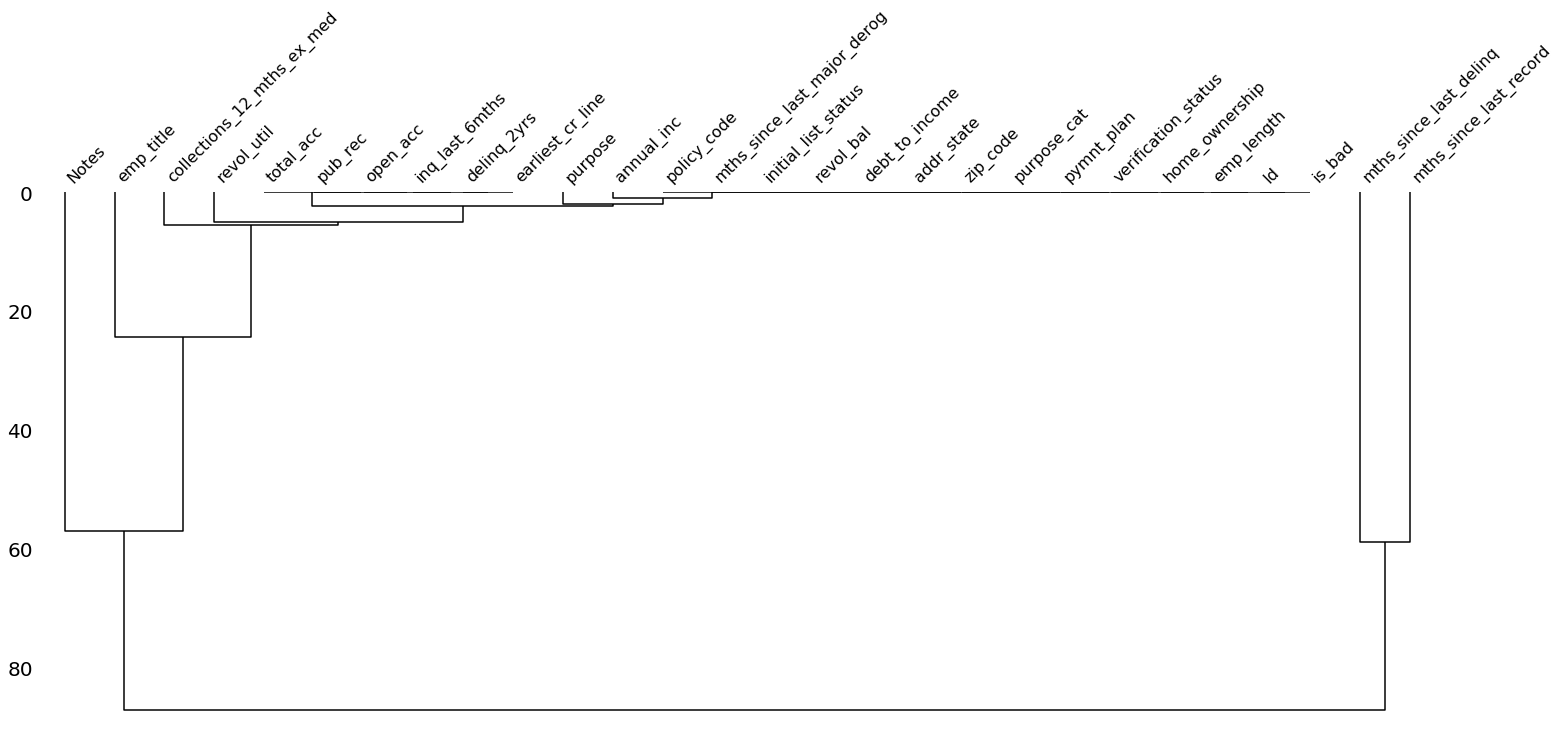

In [27]:
msno.dendrogram(pd_analysis)

Drop Cloumn with 63 % NULL Value

In [28]:
def percentage_missing_value(dataframe):
    """
        This function will return the percentage of missing values in a dataset 
        If column has over 80% missing value, del that column
    """
    if isinstance(dataframe,pd.DataFrame):
        adict={} #a dictionary conatin keys columns names and values percentage of missin value in the columns
        column = []
        for col in dataframe.columns:
            adict[col]=(np.count_nonzero(dataframe[col].isnull())*100)/len(dataframe[col])
            if adict[col] > 63:
                del adict[col]
            else:
                column.append(col)
        dataframe = dataframe.loc[:, column]
        return dataframe
    else:
        raise TypeError("method support dataframe only")
        

In [29]:
pd_analysis =percentage_missing_value(pd_analysis)

In [30]:
pd_analysis.drop(['Notes', 'emp_title','purpose','earliest_cr_line','Id','collections_12_mths_ex_med','initial_list_status'], axis=1,inplace=True)

# collections_12_mths_ex_med removed because there is no variation of data all are value as 0
# ID ,emp_title remove as the identity column of the lender person
# purpose is sub catagory of purpose_cat hence removing purpose

In [31]:
# As most of the records which has public pub record is NA are also Missing so we can consider those 5 record for the removeal
pd_analysis = pd_analysis[pd_analysis.pub_rec.notnull()]

In [32]:
group_object_cloumn  = pd_analysis.columns.to_series().groupby(pd_analysis.dtypes).groups

In [33]:
group_object_cloumn

{dtype('int64'): Index(['is_bad', 'revol_bal', 'mths_since_last_major_derog'], dtype='object'),
 dtype('float64'): Index(['annual_inc', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths',
        'open_acc', 'pub_rec', 'revol_util', 'total_acc'],
       dtype='object'),
 dtype('O'): Index(['emp_length', 'home_ownership', 'verification_status', 'pymnt_plan',
        'purpose_cat', 'zip_code', 'addr_state', 'policy_code'],
       dtype='object')}

In [34]:
# emp_length has 250 missing value so we need to have to fill na value 

pd_analysis['emp_length'] = pd.to_numeric(pd_analysis['emp_length'], errors='coerce')

In [35]:
# fill the emp_length based on the group by annual salary of the person

median_value=pd_analysis['emp_length'].median()
pd_analysis['emp_length'] =pd_analysis['emp_length'].fillna(median_value)

In [36]:
pd_analysis.isnull().sum()

is_bad                          0
emp_length                      0
home_ownership                  0
annual_inc                      0
verification_status             0
pymnt_plan                      0
purpose_cat                     0
zip_code                        0
addr_state                      0
debt_to_income                  0
delinq_2yrs                     0
inq_last_6mths                  0
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util                     21
total_acc                       0
mths_since_last_major_derog     0
policy_code                     0
dtype: int64

In [37]:
for i in pd_analysis._get_numeric_data().columns:
    pd_analysis[i] = pd_analysis[i].fillna(pd_analysis[i].median())
    
#need to consider the outier before updating to median check back 

In [38]:
pd_analysis.purpose_cat.unique()

array(['medical', 'debt consolidation', 'credit card', 'other', 'car',
       'wedding', 'other small business', 'house', 'small business',
       'educational', 'major purchase', 'home improvement', 'vacation',
       'debt consolidation small business', 'moving',
       'credit card small business', 'wedding small business',
       'small business small business', 'home improvement small business',
       'major purchase small business', 'educational small business',
       'house small business', 'renewable energy',
       'moving small business', 'medical small business',
       'vacation small business', 'car small business'], dtype=object)

Why people taking loan ?

In [39]:
loan_purposes = pd_analysis.purpose_cat.value_counts()

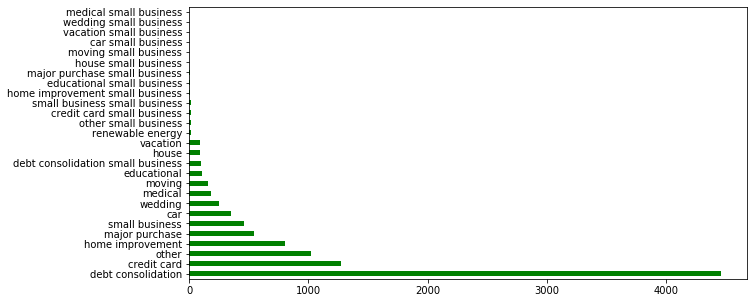

In [40]:
loan_purposes.plot.barh(figsize =(10,5),color ="green")

In [41]:
#sns.pairplot(pd_analysis,hue ="is_bad")

Text(53.75, 0.5, 'status')

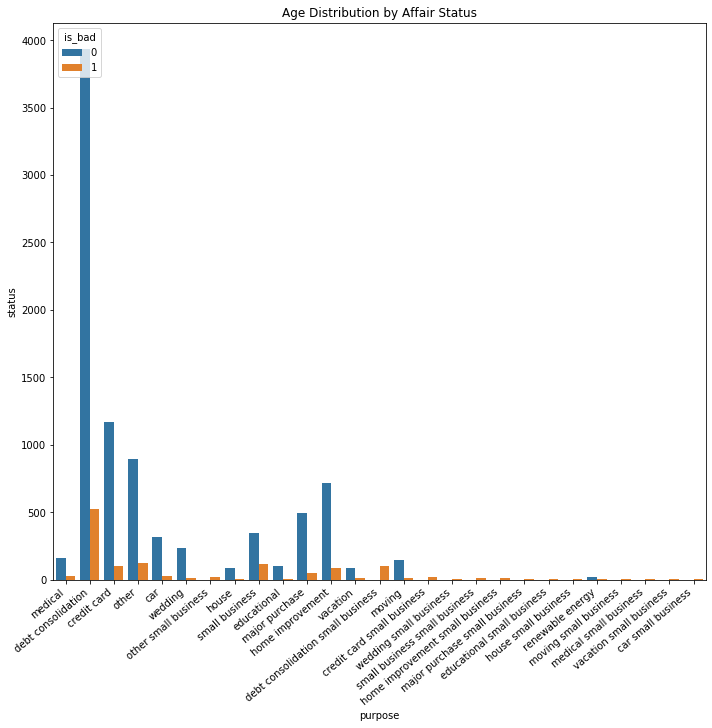

In [42]:
ax =sns.countplot(data=pd_analysis,hue='is_bad',x='purpose_cat')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Age Distribution by Affair Status')
plt.xlabel('purpose',)
plt.ylabel('status')

Text(0, 0.5, 'status')

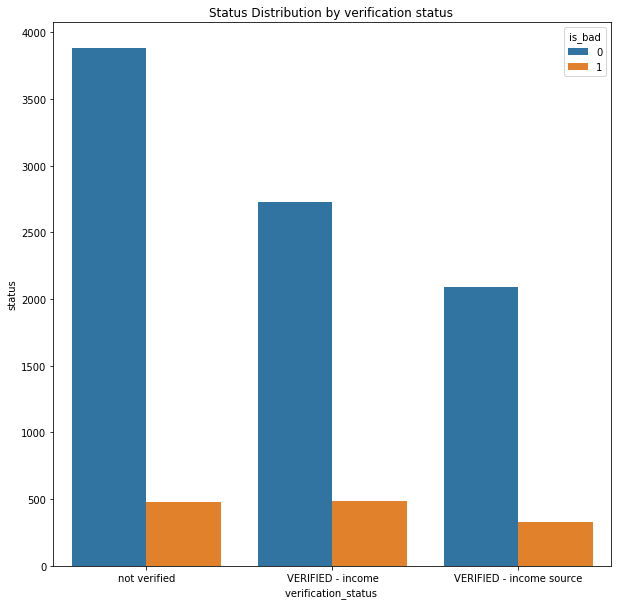

In [43]:
ax =sns.countplot(data=pd_analysis,hue='is_bad',x='verification_status')
plt.title('Status Distribution by verification status ')
plt.xlabel('verification_status ',)
plt.ylabel('status')

In [44]:
pd_no_encoder =pd_analysis.copy()

In [45]:
obj_df = pd_analysis.select_dtypes(include=['object']).copy()
obj_df.head()

,home_ownership,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,policy_code
0,MORTGAGE,not verified,n,medical,766xx,TX,PC4
1,RENT,not verified,n,debt consolidation,660xx,KS,PC1
2,RENT,not verified,n,credit card,916xx,CA,PC4
3,MORTGAGE,not verified,n,debt consolidation,124xx,NY,PC2
4,MORTGAGE,VERIFIED - income,n,debt consolidation,439xx,OH,PC3


In [46]:
for col in obj_df.columns:
    print(col,":",len(obj_df[col].unique()),'lables')

home_ownership : 4 lables
verification_status : 3 lables
pymnt_plan : 2 lables
purpose_cat : 27 lables
zip_code : 720 lables
addr_state : 50 lables
policy_code : 5 lables


In [47]:
# Create dummy variables from the feature pymnt_plan
pd_analysis = pd.get_dummies(pd_analysis, columns=["pymnt_plan"], drop_first=True)

# Create dummy variables from the feature purpose_cat
pd_analysis = pd.get_dummies(pd_analysis, columns=["purpose_cat"], drop_first=True)

# Create dummy variables from the feature home_ownership 
pd_analysis = pd.get_dummies(pd_analysis, columns=["home_ownership"], drop_first=True)

# Create dummy variables from the feature verification_status
pd_analysis = pd.get_dummies(pd_analysis, columns=["verification_status"], drop_first=True)

In [48]:
from sklearn.preprocessing import LabelEncoder

state_add = LabelEncoder()
pd_analysis['addr_state'] = state_add.fit_transform(pd_analysis['addr_state'])

policy_code = LabelEncoder()
pd_analysis['policy_code'] = policy_code.fit_transform(pd_analysis['policy_code'])

verification_status = LabelEncoder()
pd_analysis['zip_code'] = verification_status.fit_transform(pd_analysis['zip_code'])


In [49]:
pd_analysis.head()

,is_bad,emp_length,annual_inc,zip_code,addr_state,debt_to_income,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_cat_small business small business,purpose_cat_vacation,purpose_cat_vacation small business,purpose_cat_wedding,purpose_cat_wedding small business,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_VERIFIED - income source,verification_status_not verified
0,0,10.0,50000.0,555,42,10.87,0.0,0.0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,1.0,39216.0,487,16,9.15,0.0,2.0,4.0,0.0,...,0,0,0,0,0,0,0,1,0,1
2,0,4.0,65000.0,649,4,11.24,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,0,10.0,57500.0,88,33,6.18,1.0,0.0,6.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,10.0,50004.0,348,34,19.03,0.0,4.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Feature Seleciton Process

In [50]:
pd_feature_selection =pd_analysis.copy()

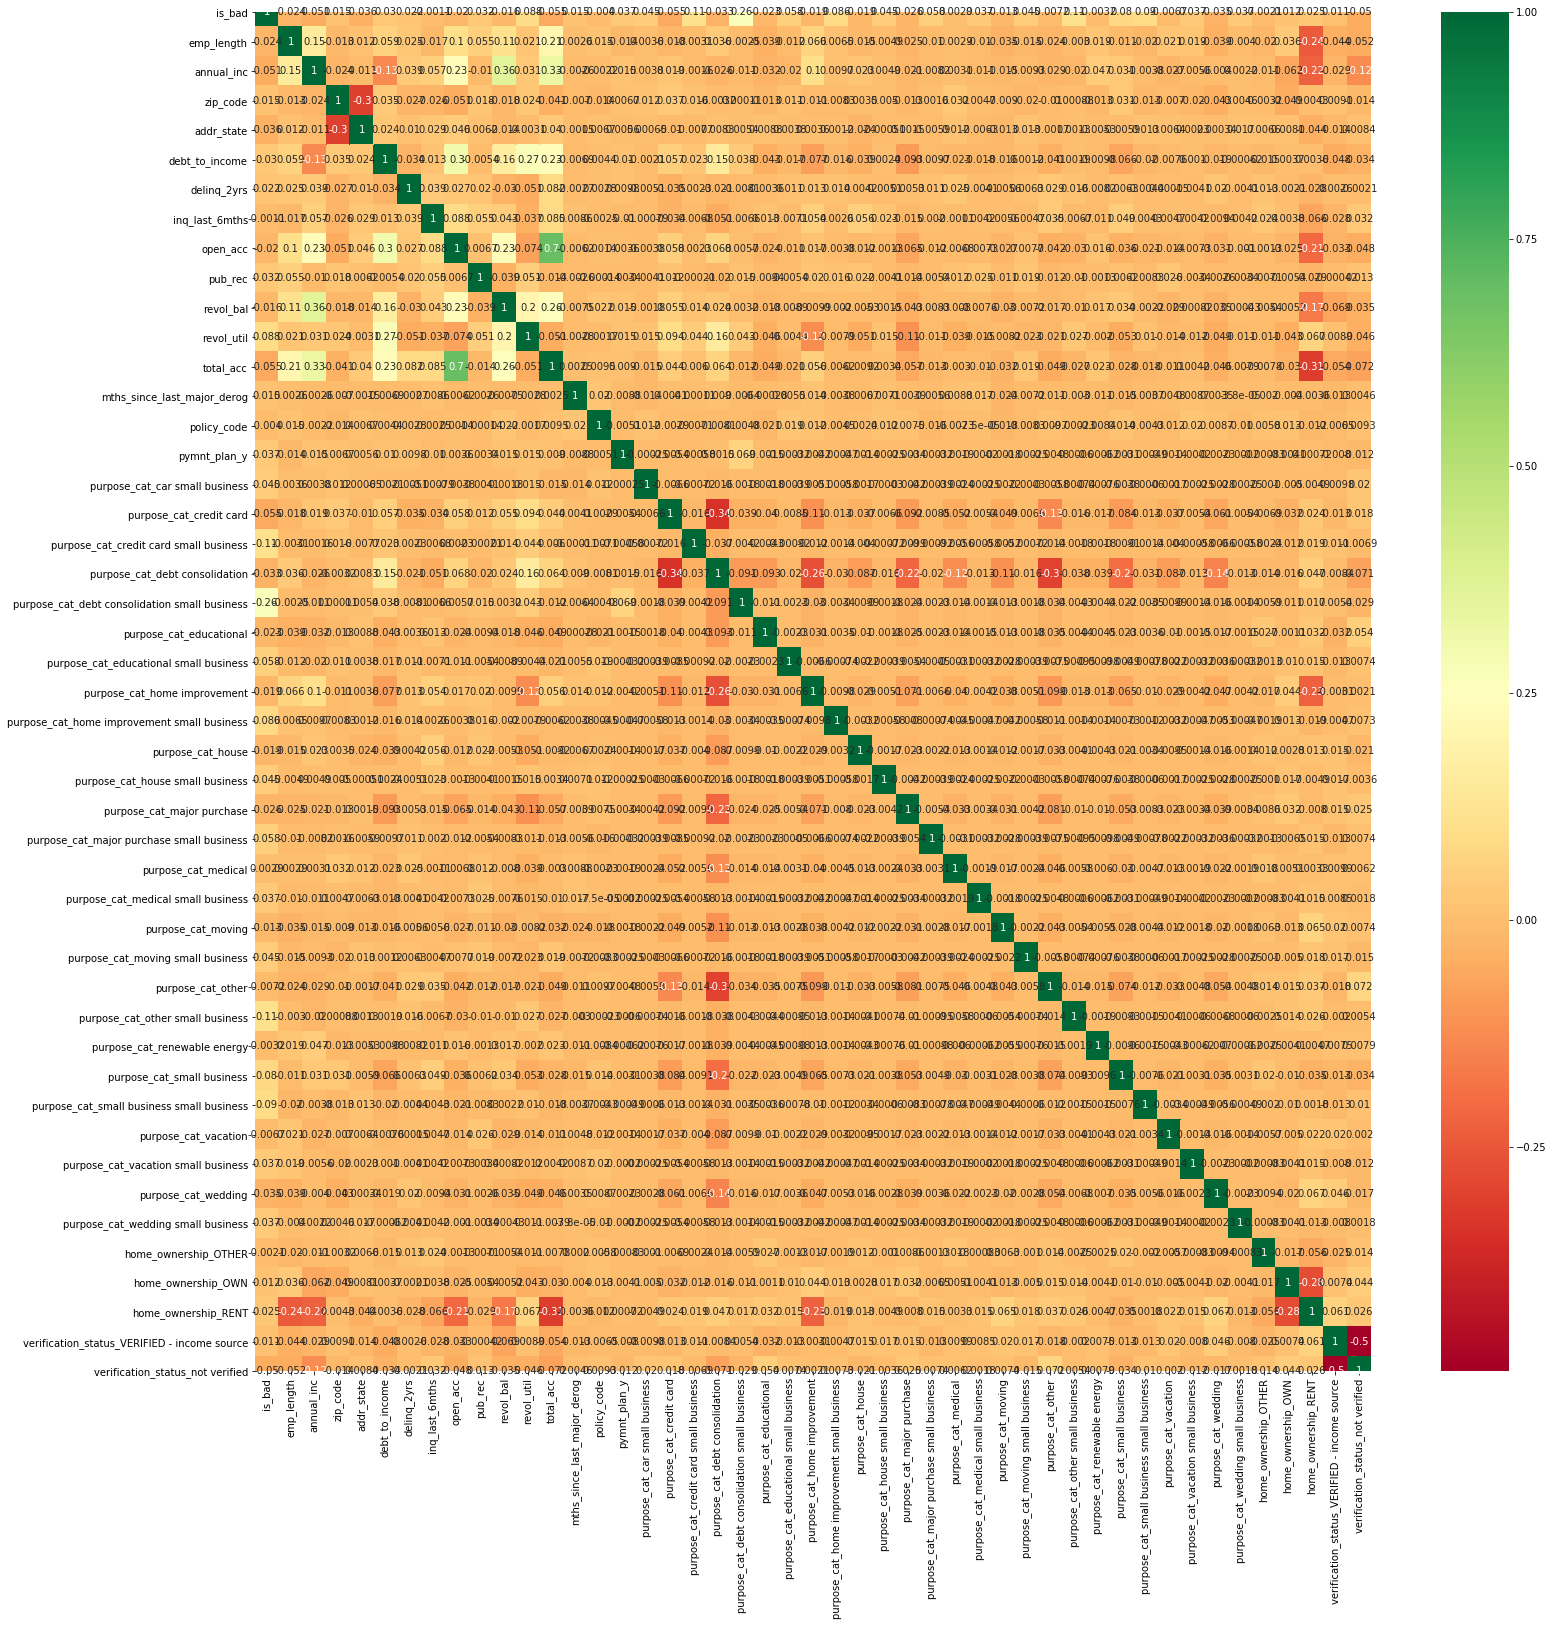

In [51]:
corrmat = pd_feature_selection.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map
g=sns.heatmap(pd_feature_selection[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [63]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# Original Data
X = pd_feature_selection.loc[:, pd_feature_selection.columns != "is_bad"].values
y = pd_feature_selection.loc[:, pd_feature_selection.columns == "is_bad"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=43, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((7996, 46), (1999, 46))


In [92]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=550, max_features=0.5,
                                criterion="entropy", class_weight="balanced")
# Build base line model -- Drop NA's
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Random forest model's average AUC: {scores.mean():.3f}")

Random forest model's average AUC: 0.681


[4.28169156e-02 9.84976883e-02 9.01792618e-02 5.49907146e-02
 9.98423796e-02 1.00348575e-02 3.91520370e-02 6.07065626e-02
 5.75970052e-03 9.96393447e-02 1.14078939e-01 8.03523766e-02
 2.06280044e-02 3.25283992e-02 1.41702781e-04 5.01120394e-04
 8.82551176e-03 5.24954756e-03 1.05545326e-02 3.81358798e-02
 8.76647970e-04 5.73061453e-04 4.62268846e-03 2.95933266e-03
 9.21989051e-04 6.52003719e-05 3.78674623e-03 4.88721714e-04
 1.94091465e-03 2.24084659e-04 1.48198148e-03 6.57478280e-04
 7.22265642e-03 3.89188799e-03 3.26545077e-04 1.12591610e-02
 1.98207085e-03 8.41613271e-04 3.57949459e-04 2.72783809e-03
 4.22681781e-04 5.45171940e-04 5.63742281e-03 1.14710200e-02
 9.70392484e-03 1.23957334e-02]


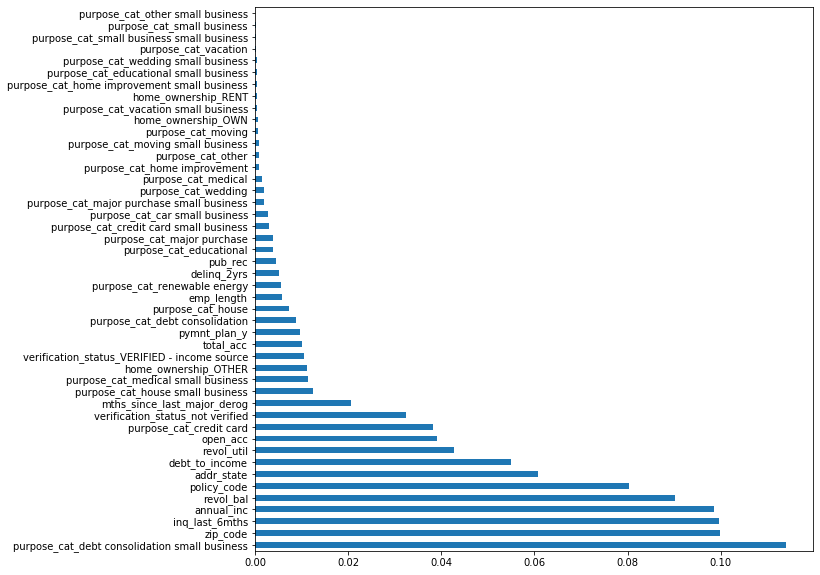

In [78]:
# fit RF to plot feature importances
rf_clf.fit(RobustScaler().fit_transform(X_train), y_train)

# Plot features importance
importances = rf_clf.feature_importances_

print(rf_clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_clf.feature_importances_, index=pd_feature_selection.columns[pd_feature_selection.columns != "is_bad"][indices],)
feat_importances.nlargest(47).plot(kind='barh')
plt.show()

In [86]:
feat_importances.nlargest(37).index

Index(['purpose_cat_debt consolidation small business', 'zip_code',
       'inq_last_6mths', 'annual_inc', 'revol_bal', 'policy_code',
       'addr_state', 'debt_to_income', 'revol_util', 'open_acc',
       'purpose_cat_credit card', 'verification_status_not verified',
       'mths_since_last_major_derog', 'purpose_cat_house small business',
       'purpose_cat_medical small business', 'home_ownership_OTHER',
       'verification_status_VERIFIED - income source', 'total_acc',
       'pymnt_plan_y', 'purpose_cat_debt consolidation', 'purpose_cat_house',
       'emp_length', 'purpose_cat_renewable energy', 'delinq_2yrs', 'pub_rec',
       'purpose_cat_educational', 'purpose_cat_major purchase',
       'purpose_cat_credit card small business',
       'purpose_cat_car small business',
       'purpose_cat_major purchase small business', 'purpose_cat_wedding',
       'purpose_cat_medical', 'purpose_cat_home improvement',
       'purpose_cat_other', 'purpose_cat_moving small business',
      

In [87]:
pd_feature_selection =pd_feature_selection[feat_importances.nlargest(37).index]

In [88]:
pd_feature_selection.head()

,purpose_cat_debt consolidation small business,zip_code,inq_last_6mths,annual_inc,revol_bal,policy_code,addr_state,debt_to_income,revol_util,open_acc,...,purpose_cat_credit card small business,purpose_cat_car small business,purpose_cat_major purchase small business,purpose_cat_wedding,purpose_cat_medical,purpose_cat_home improvement,purpose_cat_other,purpose_cat_moving small business,purpose_cat_moving,home_ownership_OWN
0,0,555,0.0,50000.0,12087,3,42,10.87,12.1,15.0,...,0,0,0,0,1,0,0,0,0,0
1,0,487,2.0,39216.0,10114,0,16,9.15,64.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,0,649,0.0,65000.0,81,3,4,11.24,0.6,4.0,...,0,0,0,0,0,0,0,0,0,0
3,0,88,0.0,57500.0,10030,1,33,6.18,37.1,6.0,...,0,0,0,0,0,0,0,0,0,0
4,0,348,4.0,50004.0,10740,2,34,19.03,40.4,8.0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
pd_analysis['is_bad'].value_counts() / pd_analysis.shape[0]

0    0.870435
1    0.129565
Name: is_bad, dtype: float64

The value_counts shows a significant class imbalance in the target column - more than 87% of the loans were paid on time.

Try OverSampling Method

In [ ]:
# Change the data set based on feature importance  Data
X = pd_feature_selection.loc[:, pd_feature_selection.columns != "is_bad"].values
y = pd_feature_selection.loc[:, pd_feature_selection.columns == "is_bad"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=43, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

In [99]:
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler
from imblearn.pipeline import make_pipeline

rf_clf = RandomForestClassifier(n_estimators=550, max_features=0.5,
                                criterion="entropy", class_weight="balanced")

rf_smote_pipline = make_pipeline(RobustScaler(),SMOTE() ,rf_clf)
scores = cross_val_score(rf_smote_pipline,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Random forest model's average AUC: {scores.mean():.3f}")

Random forest model's average AUC: 0.645


In [100]:
# Build model with oversampling
rf_oversample = make_pipeline( RobustScaler(),
                                   RandomOverSampler(),
                                   rf_clf)
scores = cross_val_score(rf_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Over-sampled model's average AUC: {scores.mean():.3f}")

Over-sampled model's average AUC: 0.673


Build Ensemble models
We’ll build ensemble models using three different models as base learners:
Gradient Boosting
Support Vector Classifier
Random Forest
The ensemble models will be built using two different methods:
Blending (average) ensemble model. Fits the base learners to the training data and then, at test time, average the predictions generated by all the base learners. Use VotingClassifier from sklearn that:
Fits all the base learners on the training data
At test time, use all base learners to predict test data and then take the average of all predictions.

In [102]:
# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [104]:
random_over_sampler = RandomOverSampler()
X_over_sample, y_over_sample = random_over_sampler.fit_sample(X_train, y_train)

In [105]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb

In [107]:
# Define base learners
xgboost_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=2,
                            subsample=0.4,
                            random_state=123)

svc_clf = SVC(gamma=0.1,
              C=0.01,
              kernel="poly",
              degree=3,
              coef0=10.0,
              probability=True)

rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2", C=100, fit_intercept=True)
# Fitting voting clf --> average ensemble
voting_clf = VotingClassifier([("xgboost", xgboost_clf),
                               ("svm", svc_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)

# fit the data which is oversample with random over sample
voting_clf.fit(X_over_sample, y_over_sample)

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.03,
                                            max_delta_step=0, max_depth=2,
                                            min_child_weight=1, missing=None,
                                            n_estimators=500, n_jobs=1,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=123, reg_alpha=0,
                                            reg_lambda=1, scale_pos...
                                                     criterion='gini',
                                          

In [109]:
xgboost_model, svm_model, rf_model = voting_clf.estimators_

In [110]:
models = {"xgb": xgb_model,
          "svm": svm_model,
          "rf": rf_model,
          "avg_ensemble": voting_clf}

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1740
           1       0.00      0.00      0.00       259

    accuracy                           0.87      1999
   macro avg       0.44      0.50      0.47      1999
weighted avg       0.76      0.87      0.81      1999

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1740
           1       0.00      0.00      0.00       259

    accuracy                           0.87      1999
   macro avg       0.44      0.50      0.47      1999
weighted avg       0.76      0.87      0.81      1999

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1740
           1       0.00      0.00      0.00       259

    accuracy                           0.87      1999
   macro avg       0.44      0.50      0.47      1999
weighted avg       0.76      0.87      0.81      1999

              preci

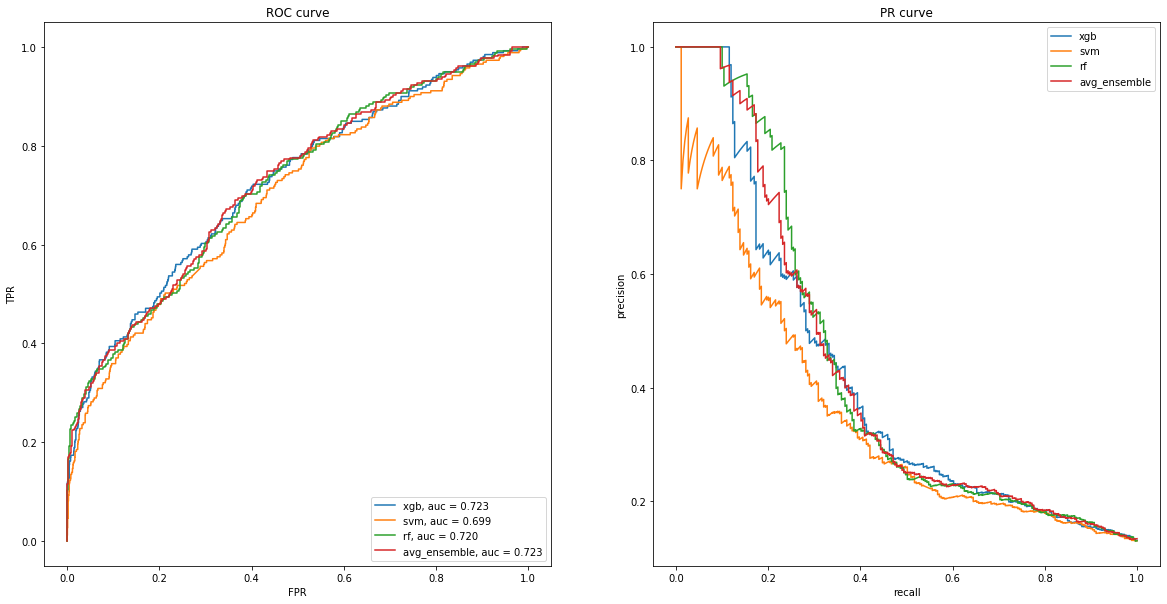

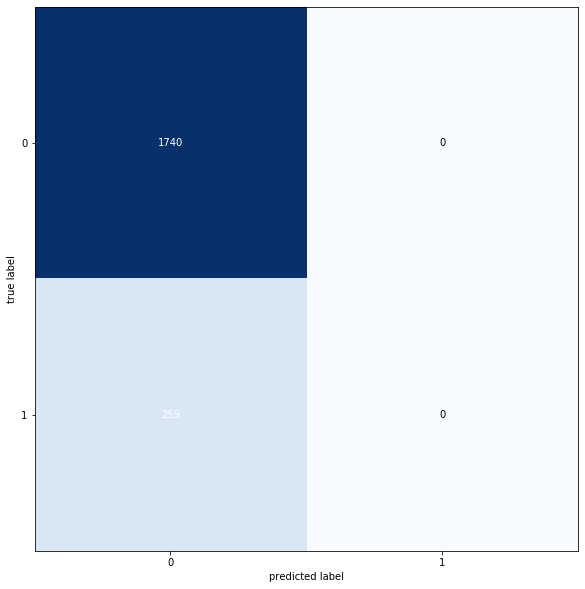

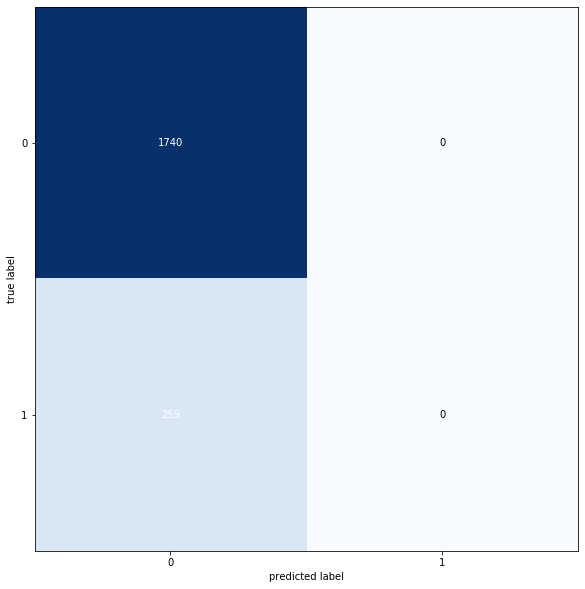

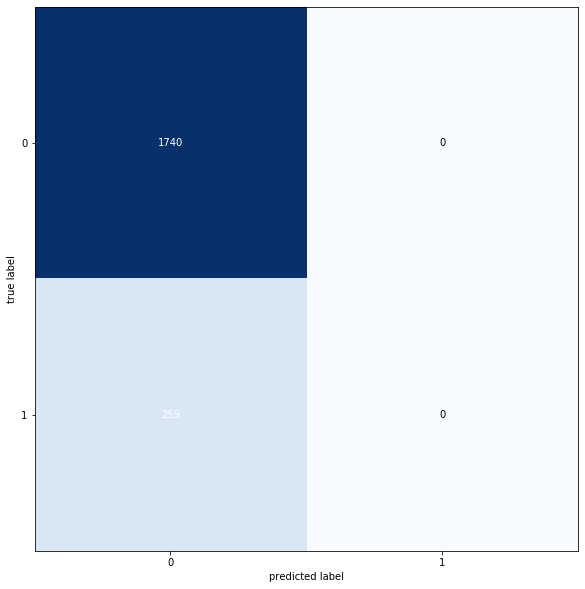

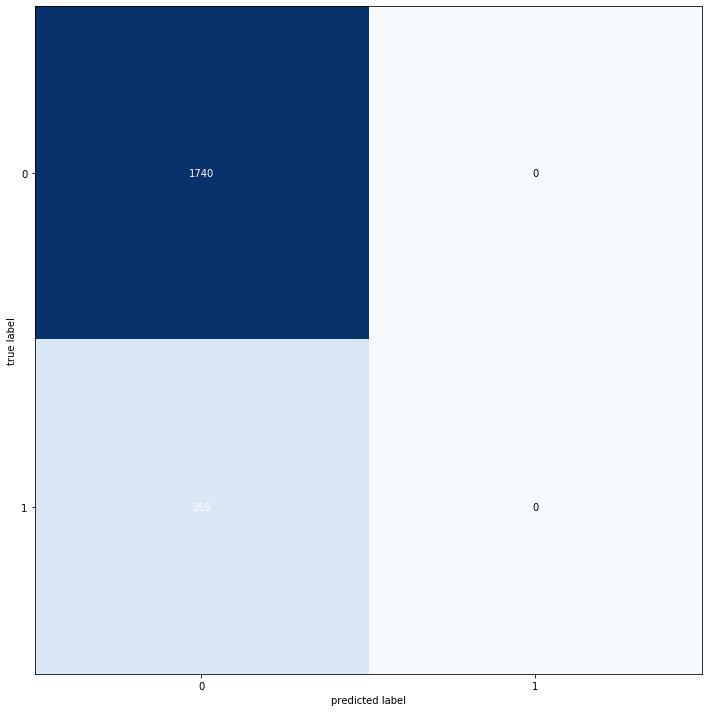

In [123]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, precision_recall_curve, f1_score

# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for name, model in models.items():    
    model_probs = model.predict_proba(X_test)[:, 1:]
    model_auc_score = roc_auc_score(y_test, model_probs)
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    axes[1].plot(recall, precision, label=f"{name}")
    
    y_pred = np.argmax(model_probs, axis=1)
    print(classification_report(y_test, (y_pred > 0.4)))
    plot_confusion_matrix(confusion_matrix(y_test, (y_pred>0.4)))



axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()
   

Best parameters : {'class_weight': {0: 0.11413793103448276, 1: 0.8858620689655172}}


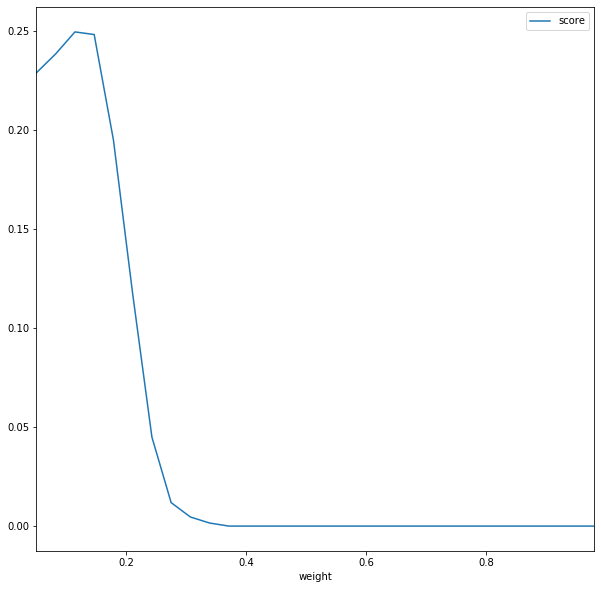

In [124]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.98, 30)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

              precision    recall  f1-score   support

           0       0.92      0.60      0.72      1740
           1       0.20      0.67      0.31       259

    accuracy                           0.61      1999
   macro avg       0.56      0.63      0.52      1999
weighted avg       0.83      0.61      0.67      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x216925404c8>)

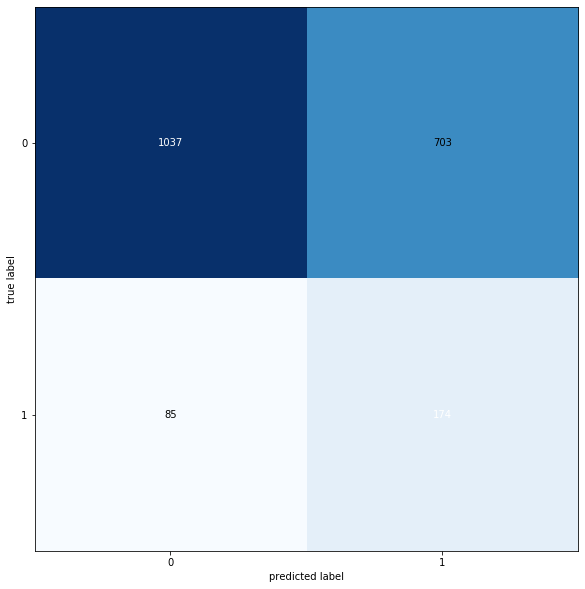

In [125]:
lr = LogisticRegression(**grid_result.best_params_)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

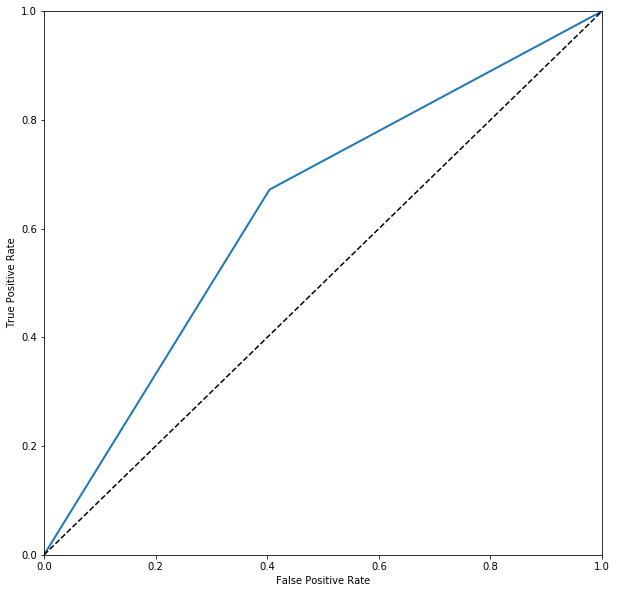

In [126]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

train neural network models for classification 
Multi-Layer PC - Perceptron Classifier We'll apply multi-layer perceptron (MLP) algorithm that trains using backpropagation. This model optimizes the log-loss function using 'lbfgs':
solver : {‘lbfgs’, ‘sgd’, ‘adam’}, default ‘adam’ The solver for weight optimization.
‘lbfgs’ is an optimizer in the family of quasi-Newton methods. ‘sgd’ refers to stochastic gradient descent. ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

In [128]:
def makeOverSamplesSMOTE(X,y):
    sm = SMOTE(sampling_strategy='all')
    X, y = sm.fit_sample(X, y)
    return X,y
        
## SMOTE only on training data

X_train_ty, y_train_ty = makeOverSamplesSMOTE(X_train, y_train)

In [129]:
from sklearn.neural_network import MLPClassifier

model_ml = MLPClassifier(solver = 'adam', alpha = 1e-5,activation='tanh', hidden_layer_sizes = (300,200), random_state = 42)
model_ml.fit(X_train_ty, y_train_ty)
pred_ml = model_ml.predict(X_test)

In [130]:
pred_ml_proba = model_ml.predict_proba(X_test)[:,1]
pred_r =model_ml.predict(X_test)

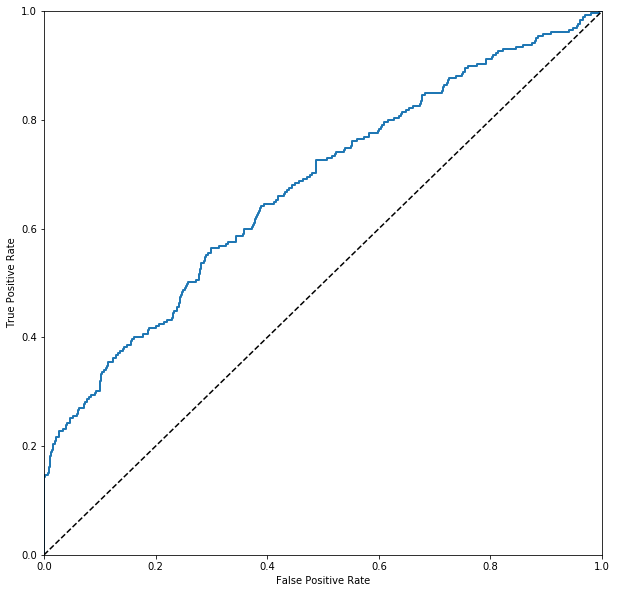

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, pred_ml_proba)
plot_roc_curve(fpr, tpr)
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1740
           1       0.32      0.30      0.31       259

    accuracy                           0.83      1999
   macro avg       0.61      0.60      0.61      1999
weighted avg       0.82      0.83      0.82      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x216930fb5c8>)

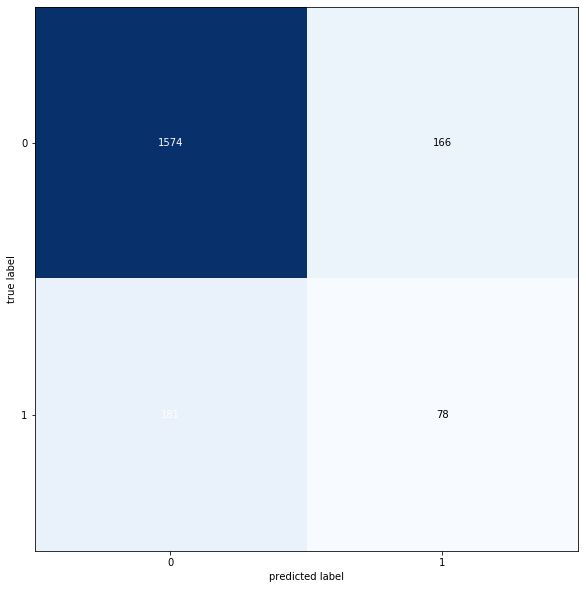

In [132]:
print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, pred_r))